### Predicting Winner in League of Legends Ranked Matches

Datasets:

Ranked Games: https://www.kaggle.com/datasnaek/league-of-legends

High ELO Ranked Games: https://www.kaggle.com/gyejr95/league-of-legends-challenger-ranked-games2020


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

### Predicting Winner in Ranked Matches

In [2]:
matches = pd.read_csv("games.csv")
matches = matches.drop(columns=["gameId", "creationTime", "seasonId"])
matches

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,1949,1,2,1,1,1,1,2,8,12,...,5,0,0,1,1,114,67,43,16,51
1,1851,1,1,1,1,0,1,1,119,7,...,2,0,0,0,0,11,67,238,51,420
2,1493,1,2,1,1,1,2,0,18,4,...,2,0,0,1,0,157,238,121,57,28
3,1758,1,1,1,1,1,1,0,57,4,...,0,0,0,0,0,164,18,141,40,51
4,2094,1,2,1,1,1,1,0,19,4,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,1944,2,1,2,2,0,2,0,19,12,...,10,2,0,4,0,55,-1,90,238,157
51486,3304,2,1,1,2,2,2,2,90,4,...,11,7,4,4,1,157,55,119,154,105
51487,2156,2,2,2,2,0,1,0,141,11,...,10,2,0,2,0,113,122,53,11,157
51488,1475,2,2,2,2,0,2,0,121,11,...,11,3,0,1,0,154,39,51,90,114


<AxesSubplot:>

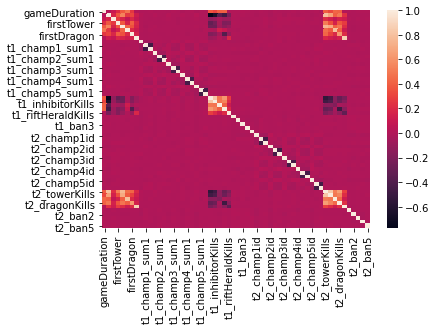

In [3]:
sns.heatmap(matches.corr())

The correlation heatmap is very busy since there are a lot of variables. This is because variables like champ and ban is unique to each individual player (5v5, 10 players total). To reduce the number of features, we can run a principal component analysis before we train a model.

In [4]:
from sklearn.preprocessing import StandardScaler

#separating features
features = matches.drop(columns=["winner"])
X = features.values
#separating target
y = matches[["winner"]].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
pca_df = pd.DataFrame(data=principalComponents, columns = ["pca1", "pca2"])

In [6]:
matches_df = pd.concat([pca_df, matches[['winner']]], axis = 1)
matches_df

,pca1,pca2,winner
0,-1.386239,1.684346,1
1,-3.230528,0.687021,1
2,-1.334931,-0.186413,1
3,-2.829351,0.619195,1
4,-2.086088,1.362895,1
...,...,...,...
51485,2.370565,-1.330256,2
51486,5.286477,4.512157,2
51487,1.675503,-1.227582,2
51488,2.233857,-2.128088,2


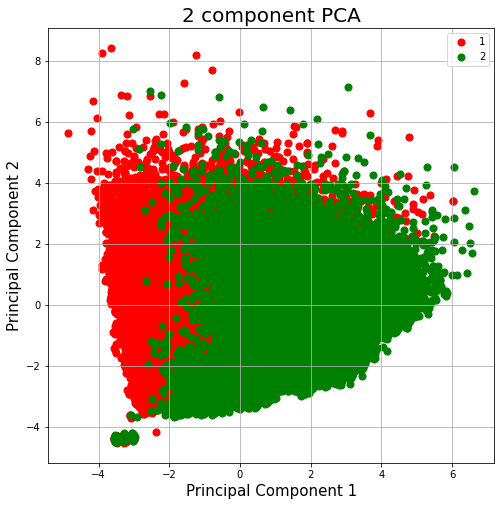

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = matches_df['winner'] == target
    ax.scatter(matches_df.loc[indicesToKeep, 'pca1'],
               matches_df.loc[indicesToKeep, 'pca2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

In [8]:
pca.explained_variance_ratio_

array([0.09486616, 0.05159787])

Running a PCA shows us that reducing the number of features may not be the best approach. The explained variance ration is a metric used to measure how much of the data k number of principal componenets can explain. In this case, the top 2 features with the "best" principal components only account for a tiny fraction of the data. This makes sense since there are, essentially, an infinite number of variables that can decide the outcome of a LoL match. With our limited data, it will be difficult to predict winners but we should move forward with keeping all features for our model.

### Decision Tree for Predicting Winner

In [21]:
X

,gameDuration,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,1949,2,1,1,1,1,2,8,12,4,...,5,0,0,1,1,114,67,43,16,51
1,1851,1,1,1,0,1,1,119,7,4,...,2,0,0,0,0,11,67,238,51,420
2,1493,2,1,1,1,2,0,18,4,7,...,2,0,0,1,0,157,238,121,57,28
3,1758,1,1,1,1,1,0,57,4,12,...,0,0,0,0,0,164,18,141,40,51
4,2094,2,1,1,1,1,0,19,4,12,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,1944,1,2,2,0,2,0,19,12,4,...,10,2,0,4,0,55,-1,90,238,157
51486,3304,1,1,2,2,2,2,90,4,14,...,11,7,4,4,1,157,55,119,154,105
51487,2156,2,2,2,0,1,0,141,11,4,...,10,2,0,2,0,113,122,53,11,157
51488,1475,2,2,2,0,2,0,121,11,4,...,11,3,0,1,0,154,39,51,90,114


A decision tree tries to make a prediction (based on features) by making decisions through splitting a node into two or more sub-nodes. In this case, the decision tree will use all available features (i.e. gameDuration, firstBlood, etc.) to make a prediction on the target, winner. The algorithm will begin with an original set as the root node. This will be the entire dataset of features. After each iteration, the algorithm goes through unused features of this set and calculates entropy and information gain of the feature, then splits the feature with the smallest entropy or largest information gain to produce a subset. The algorithm reiterates this process on each subset and goes through features that were not selected until a decision is made.


Source: https://towardsdatascience.com/a-dive-into-decision-trees-a128923c9298

In [14]:
from sklearn.model_selection import train_test_split

#separating features
X = matches.drop(columns=["winner"])
#separating target
y = matches[["winner"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

simple_tree = DecisionTreeClassifier(max_depth=4)
simple_tree.fit(X_train, y_train)
simple_predictions = simple_tree.predict(X_test)
print(metrics.confusion_matrix(y_test, simple_predictions))

[[8329  289]
 [ 383 7991]]


In [17]:
print('Accuracy Score:',metrics.accuracy_score(y_test, simple_predictions))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, simple_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, simple_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, simple_predictions)))

Accuracy Score: 0.96045197740113
Mean Absolute Error: 0.03954802259887006
Mean Squared Error: 0.03954802259887006
Root Mean Squared Error: 0.19886684640449764


In [18]:
cross_val_score(simple_tree, X, y,
                scoring="roc_auc", 
                cv=3).mean()

0.9936074225054977

In [19]:
depths = np.arange(2,10) # define the depths
results = [] # create an empty data frame for our results

for depth in depths:
    best_depth_tree = DecisionTreeClassifier(max_depth = depth) # creating an instance of a decision tree
    results.append(cross_val_score(best_depth_tree, X, y, scoring="roc_auc", # getting the cv accuracy metric for the tree at each depth
                cv=3).mean())

In [20]:
test = pd.DataFrame({'depths':depths, 'mean_roc_auc':results})
test.sort_values("mean_roc_auc", ascending=False)

,depths,mean_roc_auc
3,5,0.995267
4,6,0.995261
5,7,0.994094
2,4,0.993607
6,8,0.990361
1,3,0.988127
7,9,0.985016
0,2,0.973918
